# Baseline darts model

In [1]:
%reload_ext autoreload
%autoreload 2

# check if working in colab
try:
    # In colab
    from google.colab import drive
    drive.mount('/content/drive')

    %cd /content/drive/MyDrive/projects/paris-traffic-forecast
    %pip install -q darts

except:
    # In local
    # replace with your path
    %cd ..


/mnt/d/Google Drive/projects/paris-traffic-forecast


In [2]:
from darts import TimeSeries

import matplotlib.pyplot as plt
from utils import load_data, plot_after
from darts.metrics import rmse
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, plot_hist
from darts.datasets import AirPassengersDataset
import pandas as pd

plt.rcParams['figure.figsize'] = [20, 5]
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

## load data

In [3]:
# import data from csv
path_to_data='data/AV-champs-elysees.csv'
df = load_data(path_to_data)
df

,Identifiant arc,Libelle,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,Libelle noeud aval,Etat arc,Date debut dispo data,Date fin dispo data,geo_point_2d,geo_shape
Date et heure de comptage,,,,,,,,,,,,,,
2020-11-01 03:00:00,4264,AV_Champs_Elysees,34.0,0.40111,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.8715358799,2.30172279246","{""type"": ""LineString"", ""coordinates"": [[2.3009..."
2020-11-01 04:00:00,4264,AV_Champs_Elysees,40.0,0.48389,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.8715358799,2.30172279246","{""type"": ""LineString"", ""coordinates"": [[2.3009..."
2020-11-01 05:00:00,4264,AV_Champs_Elysees,66.0,0.75056,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.8715358799,2.30172279246","{""type"": ""LineString"", ""coordinates"": [[2.3009..."
2020-11-01 06:00:00,4264,AV_Champs_Elysees,108.0,0.99611,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.8715358799,2.30172279246","{""type"": ""LineString"", ""coordinates"": [[2.3009..."
2020-11-01 07:00:00,4264,AV_Champs_Elysees,126.0,1.09889,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.8715358799,2.30172279246","{""type"": ""LineString"", ""coordinates"": [[2.3009..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30 19:00:00,4264,AV_Champs_Elysees,1311.0,27.14111,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.8715358799,2.30172279246","{""type"": ""LineString"", ""coordinates"": [[2.3009..."
2021-11-30 20:00:00,4264,AV_Champs_Elysees,1195.0,23.34445,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.8715358799,2.30172279246","{""type"": ""LineString"", ""coordinates"": [[2.3009..."
2021-11-30 21:00:00,4264,AV_Champs_Elysees,1154.0,17.12945,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.8715358799,2.30172279246","{""type"": ""LineString"", ""coordinates"": [[2.3009..."


In [4]:
# transform data to TimeSeries
ts = TimeSeries.from_dataframe(df, 
                          value_cols=["Débit horaire", "Taux d'occupation"],
                          fill_missing_dates=True,
                          freq='H')
ts

<TimeSeries (DataArray) (Date et heure de comptage: 9477, component: 2, sample: 1)>
array([[[3.400000e+01],
        [4.011100e-01]],

       [[4.000000e+01],
        [4.838900e-01]],

       [[6.600000e+01],
        [7.505600e-01]],

       ...,

       [[1.154000e+03],
        [1.712945e+01]],

       [[1.049000e+03],
        [1.632389e+01]],

       [[9.650000e+02],
        [1.315167e+01]]])
Coordinates:
  * Date et heure de comptage  (Date et heure de comptage) datetime64[ns] 202...
  * component                  (component) object 'Débit horaire' "Taux d'occ...
Dimensions without coordinates: sample

9380 97
2020-11-01 03:00:00 2021-11-26 22:00:00
2021-11-26 23:00:00 2021-11-30 23:00:00


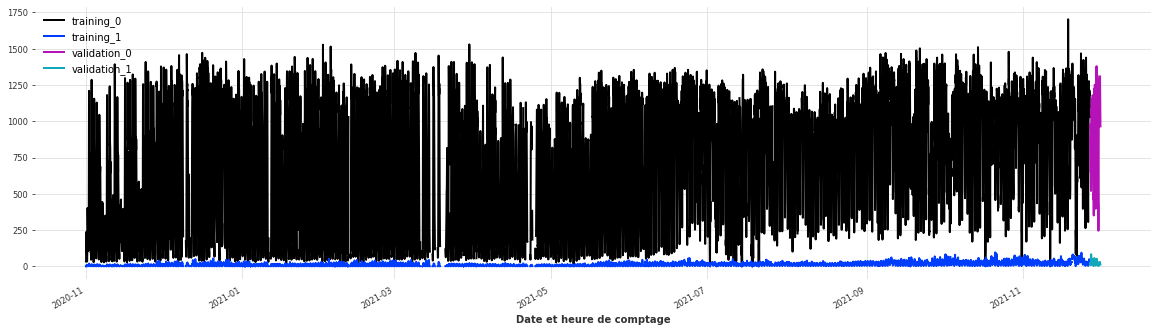

In [5]:
# train validation split
train, val = ts.split_before(ts.end_time().__sub__(pd.Timedelta(4, unit='D')))
print(len(train), len(val))
print(train.start_time(), train.end_time())
print(val.start_time(), val.end_time())
train.plot(label='training')
val.plot(label='validation')
plt.legend();

## Training model

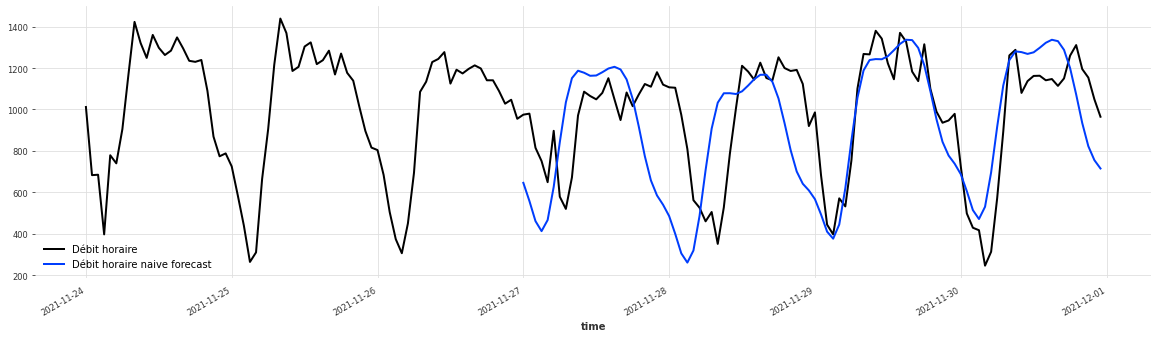

In [7]:
from darts.models import Prophet 

univariate_train = train.univariate_component(0)
univariate_val = val.univariate_component(0)
model = Prophet(country_holidays="FR")
model.fit(univariate_train)
naive_forecast = model.predict(len(univariate_val))

start_time = naive_forecast.start_time() - pd.Timedelta(3, unit='D')
plot_after(ts, 0, start_time)
plot_after(naive_forecast, 0, start_time, label='Débit horaire naive forecast')
plt.legend();

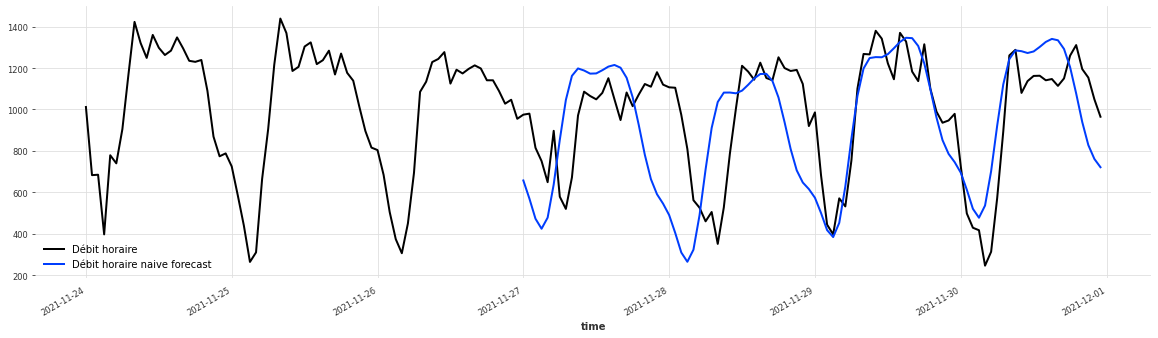

In [19]:
from darts.models import Prophet 

univariate_train = train.univariate_component(0)
univariate_val = val.univariate_component(0)
model = Prophet(add_seasonalities={'name':"hourly seasonality", "seasonal_periods":24, "fourier_order":1} ,country_holidays="FR")
model.fit(univariate_train)
naive_forecast = model.predict(len(univariate_val))

start_time = naive_forecast.start_time() - pd.Timedelta(3, unit='D')
plot_after(ts, 0, start_time)
plot_after(naive_forecast, 0, start_time, label='Débit horaire naive forecast')
plt.legend();

In [8]:
model.backtest(univariate_train, forecast_horizon=len(univariate_val), start=0.8, stride=24, metric=rmse)


282.24574704068544

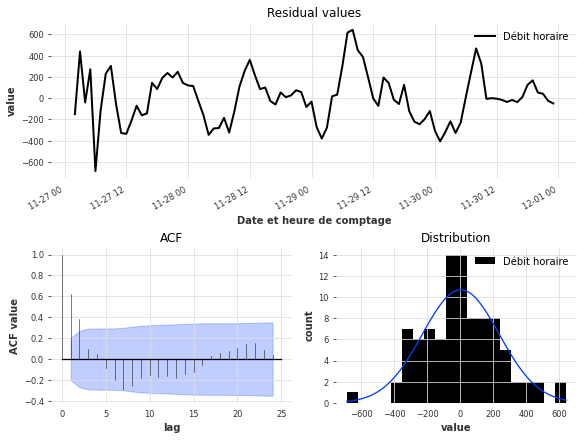

In [20]:
plot_residuals_analysis(model.residuals(univariate_val))